# 추가사항
#### V3.3_주차수요예측(최종)
#### 궁금증 추가
#### PlaceParkingDivision, MyCeil, HyphenDataProc 함수 추가

In [117]:
import pandas as pd
import numpy as np

# 데이터 불러오기

In [118]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

# 전용면적당 법정주차대수 

## 법정주차대수 Column 추가

In [119]:
train.insert(loc=14, column='법정주차대수', value=0.0)

In [122]:
train['공급유형 '] = np.where(train['공급유형'] =='장기전세',0,0)

## 전용면적을 지역별 각 지역 기준으로 나누기

In [120]:
def PlaceParkingDivision(dataframe, place_colNames ,denominatorLessNum, denominatorExceedNum):
    df = dataframe.copy()
    
    for colName in place_colNames:
        idx = df[ (df['지역'] == colName) & (df['전용면적'] <= 85) ].index
        df.loc[idx, '법정주차대수'] = df[(df['지역'] == colName) & (df['전용면적'] <= 85) ]['전용면적'] / denominatorLessNum
        idx = df[(df['지역'] == colName) & (train['전용면적'] > 85) ].index
        df.loc[idx, '법정주차대수'] = df[(df['지역'] == colName) & (df['전용면적'] > 85) ]['전용면적'] / denominatorExceedNum
        
    return df

In [102]:
# for문 columns 설정
Gwang_colNames = ['부산광역시', '대전광역시', '광주광역시', '울산광역시', '대구광역시', '세종특별자치시', '경기도']
Other_colNames = ['경상북도', '경상남도', '전라북도', '전라남도', '강원도', '충청남도', '충청북도', '제주특별자치도']

# Train
# 1. 서울특별시 
# - 전용면적 {85이하 - 75} | {85초과 - 65} 나누기
train = PlaceParkingDivision(train, ['서울특별시'], 75, 65)

# 2. 광역시 + 경기도
# - 전용면적 {85이하 - 85} | {85초과 - 70} 나누기
train = PlaceParkingDivision(train, Gwang_colNames, 85, 70)
    
# 강원도, 충청남도 등 (1과 2 제외한 나머지 지역 OO도)
# - 전용면적 {85이하 - 95} | {85초과 - 75} 나누기
train = PlaceParkingDivision(train, Other_colNames, 95, 75)
    
# Test
# 2. 광역시 + 경기도
# - 전용면적 {85이하 - 85} | {85초과 - 70} 나누기
test = PlaceParkingDivision(test, Gwang_colNames, 85, 70)
    
# 강원도, 충청남도 등 (1과 2 제외한 나머지 지역 OO도)
# - 전용면적 {85이하 - 95} | {85초과 - 75} 나누기
test = PlaceParkingDivision(test, Other_colNames, 95, 75)

<ipython-input-101-f27beae5bf0b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx = df[(df['지역'] == colName) & (train['전용면적'] > 85) ].index
<ipython-input-101-f27beae5bf0b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx = df[(df['지역'] == colName) & (train['전용면적'] > 85) ].index
<ipython-input-101-f27beae5bf0b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx = df[(df['지역'] == colName) & (train['전용면적'] > 85) ].index
<ipython-input-101-f27beae5bf0b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx = df[(df['지역'] == colName) & (train['전용면적'] > 85) ].index
<ipython-input-101-f27beae5bf0b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx = df[(df['지역'] == colName) & (train['전용면적'] > 85) ].index
<ipython-input-101-f27beae5bf0b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx = 

## 법정주차대수 소수점 정리

In [103]:
def MyCeil(dataframe, place_colNames):
    df = dataframe.copy()
    
    for colName in place_colNames:
        idx = df[ df['지역'] == colName ].index
        df.loc[idx, '법정주차대수'] = np.ceil(df[ df['지역'] == colName ]['법정주차대수'])
        
    return df

In [104]:
# Train
# 1. 서울특별시 
# 1) 전용면적 30이하 : 0.5 고정
idx = train[ (train['지역'] == '서울특별시') & (train['전용면적'] <= 30) ].index
train.loc[idx, '법정주차대수'] = 0.5

# 2) 전용면적 30초과 ~ 60이하 : 0.8 고정
idx = train[ (train['지역'] == '서울특별시') & (train['전용면적'] > 30) & (train['전용면적'] <= 60) ].index
train.loc[idx, '법정주차대수'] = 0.8

# 3) 전용면적 60초과 : 1.xxx -> 2 or 2.xxxx -> 3
# - 나머지가 조금이라도 나오면 몫의 값 + 1 => np.ceil 함수 사용
idx = train[ (train['지역'] == '서울특별시') & (train['전용면적'] > 60) ].index
train.loc[idx, '법정주차대수'] = np.ceil(train[ (train['지역'] == '서울특별시') & (train['전용면적'] > 60) ]['법정주차대수'])

# 2. 광역시 + 경기도
# - 필요한 조건은 앞서 한 조건(나누기 작업)만 하면 되기 때문에 소수점 올림만 작업하면 된다.
train = MyCeil(train, Gwang_colNames)

# 3. 강원도, 충청남도 등 (1과 2 제외한 나머지 지역 OO도)
# - 필요한 조건은 앞서 한 조건(나누기 작업)만 하면 되기 때문에 소수점 올림만 작업하면 된다.
train = MyCeil(train, Other_colNames)
    
# Test
# 2. 광역시 + 경기도
# - 필요한 조건은 앞서 한 조건(나누기 작업)만 하면 되기 때문에 소수점 올림만 작업하면 된다.
test = MyCeil(test, Gwang_colNames)

# 3. 강원도, 충청남도 등 (1과 2 제외한 나머지 지역 OO도)
# - 필요한 조건은 앞서 한 조건(나누기 작업)만 하면 되기 때문에 소수점 올림만 작업하면 된다.
test = MyCeil(test, Other_colNames)

# 컬럼명 바꾸기

In [105]:
train = train.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철',
                     '도보 10분거리 내 버스정류장 수':'버스'})

test = test.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철',
                     '도보 10분거리 내 버스정류장 수':'버스'})

# 결측치 처리

In [106]:
# 이유 : 같은 단지코드끼리 자격 유형이 A로 동일함 

test[test['단지코드'] == 'C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,법정주차대수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0.0,2.0,840.0,1.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0.0,2.0,840.0,1.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0.0,2.0,840.0,1.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0,NaN
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0.0,2.0,840.0,NaN


In [107]:
# 이유 : 임대료와 임대보증금이 존재 하는 데이터의 자격 유형이 C라서 C로 대체

test[test['단지코드'] == 'C2253']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,법정주차대수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0,1.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0.0,2.0,173.0,1.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0.0,2.0,173.0,NaN
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0.0,2.0,173.0,1.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0.0,2.0,173.0,1.0
263,C2253,1161,상가,강원도,임대상가,22.91,1,0.0,D,NaN,NaN,0.0,2.0,173.0,1.0
264,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0,1.0
265,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0,1.0
266,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0,1.0
267,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0,1.0


In [108]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

In [109]:
train[train['임대보증금'] == '-']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,법정주차대수,등록차량수
2547,C1326,1934,아파트,부산광역시,국민임대,24.72,472,43.0,H,-,-,0.0,4.0,1670.0,1.0,1153.0
2548,C1326,1934,아파트,부산광역시,국민임대,24.79,104,43.0,H,-,-,0.0,4.0,1670.0,1.0,1153.0
2549,C1326,1934,아파트,부산광역시,국민임대,26.83,590,43.0,H,-,-,0.0,4.0,1670.0,1.0,1153.0
2550,C1326,1934,아파트,부산광역시,국민임대,37.70,464,43.0,H,-,-,0.0,4.0,1670.0,1.0,1153.0
2551,C1326,1934,아파트,부산광역시,국민임대,46.94,304,43.0,H,-,-,0.0,4.0,1670.0,1.0,1153.0
2680,C1786,480,아파트,강원도,행복주택,16.91,156,25.0,K,-,-,0.0,3.0,338.0,1.0,345.0
2681,C1786,480,아파트,강원도,행복주택,26.90,136,25.0,K,-,-,0.0,3.0,338.0,1.0,345.0
2682,C1786,480,아파트,강원도,행복주택,26.90,72,25.0,K,-,-,0.0,3.0,338.0,1.0,345.0
2683,C1786,480,아파트,강원도,행복주택,26.90,24,25.0,K,-,-,0.0,3.0,338.0,1.0,345.0
2906,C2186,924,아파트,대구광역시,국민임대,29.17,238,0.0,H,-,-,0.0,8.0,664.0,1.0,744.0


In [116]:
train[train['임대료'] == '-']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,법정주차대수,등록차량수
2043,C1397,370,아파트,서울특별시,장기전세,23.32,51,9.0,A,87444000,-,0.0,3.0,1590.0,0.5,1595.0
2044,C1397,370,아파트,서울특별시,장기전세,46.79,4,9.0,A,174888000,-,0.0,3.0,1590.0,0.8,1595.0
2045,C1397,370,아파트,서울특별시,장기전세,46.91,69,9.0,A,174888000,-,0.0,3.0,1590.0,0.8,1595.0
2046,C1397,370,아파트,서울특별시,장기전세,51.96,24,9.0,A,194562000,-,0.0,3.0,1590.0,0.8,1595.0
2047,C1397,370,아파트,서울특별시,장기전세,51.99,80,9.0,A,194562000,-,0.0,3.0,1590.0,0.8,1595.0
2048,C1397,370,아파트,서울특별시,장기전세,59.93,142,9.0,A,216423000,-,0.0,3.0,1590.0,0.8,1595.0
2100,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000,-,0.0,3.0,673.0,0.8,645.0
2101,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000,-,0.0,3.0,673.0,0.8,645.0
2102,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000,-,0.0,3.0,673.0,0.8,645.0


# '-' 데이터 처리

In [111]:
def HyphenDataProc(dataframe, demandName, qualificationName, getName, collection_range):
    df = dataframe.copy()
    cost_mean = []
    
    # 수집할 +/- 범위
    collection_range = collection_range
    
    # 자격유형 'H'이면서  임대료/임대보증금 '-'인 것들의 전용면적 가져오기
    area_list = df[(df[getName]=='-')&(df['자격유형']==qualificationName)]['전용면적'].to_list()

    # 조건문
    # '국민임대' & 'H' & '-' & 면적-0.5 이상 & 면적+0.5 이하 
    for area in area_list:
        cost_mean.append( np.mean(df[ (df['공급유형'] == demandName) & (df['자격유형'] == qualificationName) & (df[getName] != '-') 
          & (df['전용면적'] >= (area-collection_range)) & (df['전용면적'] <= (area+collection_range)) ][getName].values.astype(float)) )

    # 데이터 입력
    idx = df[(df[getName]=='-')&(df['자격유형']==qualificationName)].index
    df.loc[idx, getName] = cost_mean
    
    return df

## 유형별 임대보증금/임대료 '-' 데이터 처리

In [112]:
# Train 공급유형 '국민임대' & 자격유형 'H' & 임대료/임대보증금 '-' 데이터 처리
train = HyphenDataProc(train, '국민임대', 'H', '임대료', 0.5)
train = HyphenDataProc(train, '국민임대', 'H', '임대보증금', 0.5)

# Train 공급유형 '행복주택' & 자격유형 'K' & 임대료/임대보증금 '-' 데이터 처리
train = HyphenDataProc(train, '행복주택', 'K', '임대료', 0.5)
train = HyphenDataProc(train, '행복주택', 'K', '임대보증금', 0.5)

train = HyphenDataProc(train, '행복주택', 'K', '임대료', 0.5)
train = HyphenDataProc(train, '행복주택', 'K', '임대보증금', 0.5)

# Test 공급유형 '행복주택' & 자격유형 'L' & 임대료/임대보증금 '-' 데이터 처리
test = HyphenDataProc(test, '행복주택', 'L', '임대료', 0.5)
test = HyphenDataProc(test, '행복주택', 'L', '임대보증금', 0.5)

# Test 공급유형 '영구임대' & 자격유형 'C' & 임대료/임대보증금 '-' 데이터 처리
test = HyphenDataProc(test, '영구임대', 'C', '임대료', 1.5)
test = HyphenDataProc(test, '영구임대', 'C', '임대보증금', 1.5)

# 지하철 Y or N로 변경

In [24]:
train['지하철'] = np.where(train['지하철'] == 0, 0, 1)
test['지하철'] = np.where(test['지하철'] == 0, 0, 1)

# 법정주차수요 만들기

In [28]:
value = train['총세대수'] * train['법정주차대수']
train.insert(loc=15, column='법정주차수요', value=value)

value = test['총세대수'] * test['법정주차대수']
test['법정주차수요'] = value

# 아파트 / 상가 데이터 분리

In [29]:
# Train
apart_train = train[train['임대건물구분'] == '아파트']
shop_train = train[train['임대건물구분'] == '상가']

# Test
apart_test = test[test['임대건물구분'] == '아파트']
shop_test = test[test['임대건물구분'] == '상가']

In [30]:
pd.DataFrame(apart_train.corr()['등록차량수'].sort_values(ascending=False))

,등록차량수
등록차량수,1.000000
단지내주차면수,0.837863
법정주차수요,0.655437
총세대수,0.652807
전용면적,0.320422
버스,0.120208
전용면적별세대수,0.101574
법정주차대수,0.038373
공가수,0.033765
지역,0.023440


# scaling 시각화

In [61]:
scailing_features = ['총세대수',
                     '전용면적',
                     '전용면적별세대수',
                     '공가수',
                     '임대보증금',
                     '임대료',
                     '단지내주차면수',
                     '법정주차수요',]

# 임대보증금,임대료가 object 이므로 시각화를 위해 float64로 변경

apart_train_data = apart_train_data.astype('float64')
shop_train_data = apart_train_data.astype('float64')

In [78]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 아파트인경우

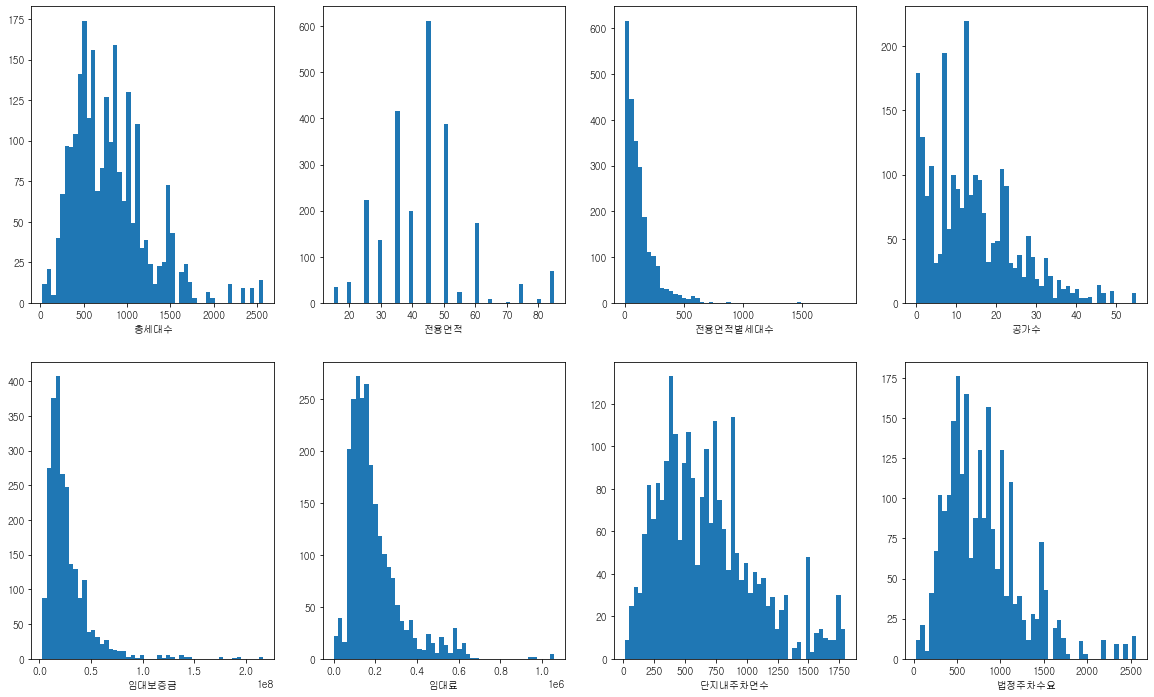

In [79]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,4, figsize= (20,12))
i = 0
for f in scailing_features:
    c = i % 4
    r = i // 4
    plt.subplot(2, 4, i+1)
    plt.hist(x = f, bins =50, data = apart_train_data)
    plt.xlabel(f)
    i += 1
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,4, figsize= (20,12))
i = 0
for f in scailing_features:
    c = i % 4
    r = i // 4
    plt.subplot(2, 4, i+1)
    plt.hist(x = f, bins =50, data = apart_train_data)
    plt.xlabel(f)
    i += 1
plt.show()

# 상가인 경우

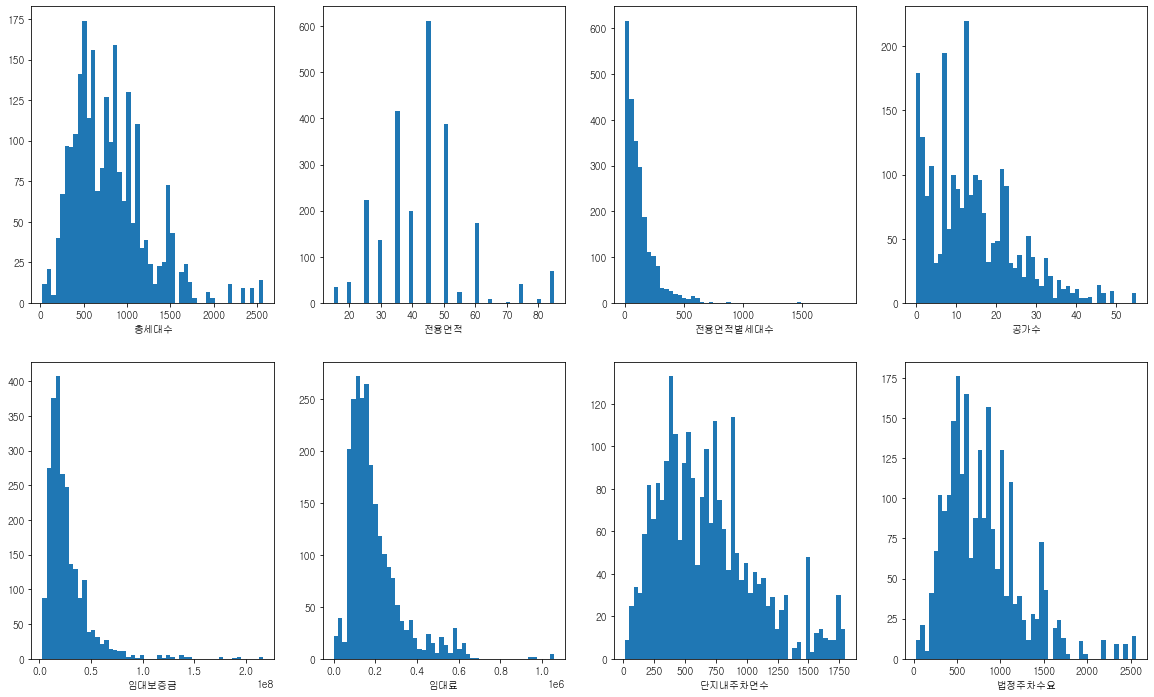

In [80]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,4, figsize= (20,12))
i = 0
for f in scailing_features:
    c = i % 4
    r = i // 4
    plt.subplot(2, 4, i+1)
    plt.hist(x = f, bins =50, data = shop_train_data)
    plt.xlabel(f)
    i += 1
plt.show()